# Árvore de decisão — Heurística para escolher o melhor valor de cada característica

## Definir implementações

### Funções utilitárias

In [1]:
from collections import Counter
from typing import Tuple
from numpy import ndarray


def most_frequently(y: ndarray):
    return Counter(y.flat).most_common(1)[0][0]


def gini_impurity(y: ndarray) -> float:
    labels = sorted(set(y))
    probabilities = numpy.zeros(shape=(len(labels),))

    for index, key in enumerate(labels):
        probabilities[index] = sum(y == key) / len(y)
    return 1 - sum(probabilities ** 2)


def impurity_value(x: ndarray, y: ndarray, value) -> Tuple[float, float, float]:
    greater = x > value
    impurity_gt = gini_impurity(y[greater])
    probability_gt = sum(greater) / len(y)
    impurity_lte = gini_impurity(y[~greater])
    probability_lte = sum(~greater) / len(y)
    total_impurity = impurity_gt * probability_gt + impurity_lte * probability_lte
    return total_impurity, impurity_gt, impurity_lte


def best_value(x: ndarray, y: ndarray) -> Tuple[float, float]:
    result = None
    min_impurity = float('inf')
    x_max = numpy.max(x)
    x_min = numpy.min(x)

    while True:
        mean_value = (x_min + x_max) / 2
        total_impurity, greater_impurity, less_impurity = impurity_value(x, y, mean_value)

        if total_impurity < min_impurity:
            min_impurity = total_impurity
            result = mean_value

            if greater_impurity == 0 or less_impurity == 0:
                break

            if greater_impurity < less_impurity:
                x_min = mean_value

            else:
                x_max = mean_value
        else:
            break

    return result, min_impurity


def best_feature(x: ndarray, y: ndarray):
    impurities = []
    values = []

    for feature in range(x.shape[1]):
        value, impurity = best_value(x[:, feature], y)
        impurities.append(impurity)
        values.append(value)
    impurities = numpy.array(impurities)
    feature = numpy.argmin(impurities)
    return feature, values[feature], impurities[feature]

In [2]:
from sklearn.dummy import DummyClassifier
from typing import Callable, TypedDict, Any
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from pandas import DataFrame

class ModelResult(TypedDict):
    predict: float
    cross_val: float


def fit_predict(classifier_factory: Callable[[], Any], x: ndarray, y: ndarray) -> ModelResult:
    classifier = classifier_factory()
    classifier.fit(x, y)
    predict = classifier.predict(x)
    cross_val = cross_val_score(classifier_factory(), x, y)
    return {'predict': predict, 'cross_val': numpy.mean(cross_val)}


def show_comparison(x: ndarray, y: ndarray):
    result_zero_r = fit_predict(lambda: DummyClassifier(strategy="most_frequent"), x, y)
    result_tree = fit_predict(lambda: Tree(), x, y)
    result_my_tree = fit_predict(lambda: MyTree(), x, y)
    result_scikit_tree = fit_predict(lambda: DecisionTreeClassifier(random_state=seed), x, y)
    result = {
        'Acurácia': [
            accuracy_score(y, result_zero_r['predict']),
            accuracy_score(y, result_tree['predict']),
            accuracy_score(y, result_scikit_tree['predict']),
            accuracy_score(y, result_my_tree['predict']),
        ],
        'Validação cruzada (média)': [
            result_zero_r['cross_val'],
            result_tree['cross_val'],
            result_scikit_tree['cross_val'],
            result_my_tree['cross_val'],
        ]
    }
    columns = ['Zero R', 'Árvore (prof.)', 'Árvore (scikit)', 'Árvore (minha)']
    return DataFrame.from_dict(result, orient='index', columns=columns)

In [3]:
import random

# Semente para reprodutibilidade dos resultados
seed = 13

random.seed(seed)

### Implementação do professor

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin


class Tree(BaseEstimator, ClassifierMixin):

    def fit(self, x: ndarray, y: ndarray):
        self.feature, self.value, self.impurity = best_feature(x, y)
        self.value = numpy.mean(x[:, self.feature])
        greater = x[:, self.feature] > self.value

        if sum(greater) > 0 and sum(~greater) > 0:
            self.greater = Tree()
            self.greater.fit(x[greater, :], y[greater])
            self.lte = Tree()
            self.lte.fit(x[~greater, :], y[~greater])

        else:
            self.answer = most_frequently(y)

    def predict(self, x: ndarray):
        y = numpy.empty((x.shape[0]), dtype=numpy.int8)

        if hasattr(self, 'answer'):
            y[:] = self.answer

        else:
            greater = x[:, self.feature] > self.value
            y[greater] = self.greater.predict(x[greater, :])
            y[~greater] = self.lte.predict(x[~greater, :])

        return y

### Heurística escolhida

In [5]:
def random_feature(data: ndarray) -> Tuple[int, float]:
    feat = random.randint(0, data.shape[1] - 1)
    x_min = numpy.min(data[:, feat])
    x_max = numpy.max(data[:, feat])
    valor = random.random() * (x_max - x_min) + x_min
    return feat, valor


class MyTree(Tree):

    def fit(self, x: ndarray, y: ndarray):
        self.feature, self.value = random_feature(x)
        greater = x[:, self.feature] > self.value

        if sum(greater) > 0 and sum(~greater) > 0:
            self.greater = MyTree()
            self.greater.fit(x[greater, :], y[greater])
            self.lte = MyTree()
            self.lte.fit(x[~greater, :], y[~greater])

        else:
            self.answer = most_frequently(y)

## Dataset: Iris

### Carregamento

In [6]:
from sklearn.datasets import load_iris

iris_dataset = load_iris()
iris_x, iris_y = iris_dataset.data[:, 2:], iris_dataset.target

### Comparação: Regiões de decisão

In [7]:
import numpy
import matplotlib.pyplot as plot


def plot_2d_decision_regions(model, x: ndarray, y: ndarray):
    model.fit(x, y)
    delta, n_points = 0.2, 100
    x0_vals = numpy.linspace(numpy.min(x[:, 0]) - delta, numpy.max(x[:, 0]) + delta, n_points)
    x1_vals = numpy.linspace(numpy.min(x[:, 1]) - delta, numpy.max(x[:, 1]) + delta, n_points)
    x0, x1 = numpy.meshgrid(x0_vals, x1_vals)
    x_dec = numpy.c_[x0.ravel(), x1.ravel()]
    prediction = model.predict(x_dec)
    plot.contourf(x0, x1, prediction.reshape(x0.shape), alpha=0.25)

    for key in set(y):
        plot.plot(x[:, 0][y == key], x[:, 1][y == key], 'o', label=f"{iris_dataset.target_names[key]} [{key}]")
    plot.xlabel(f"X[0]: {iris_dataset.feature_names[0]}")
    plot.ylabel(f"X[1]: {iris_dataset.feature_names[1]}")
    plot.show()


#### Implementação do professor

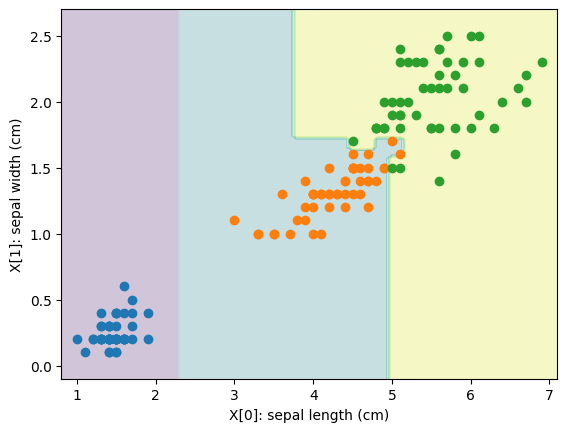

In [8]:
from sklearn.tree import DecisionTreeClassifier

tree = Tree()
plot_2d_decision_regions(tree, iris_x, iris_y)

#### Minha implementação

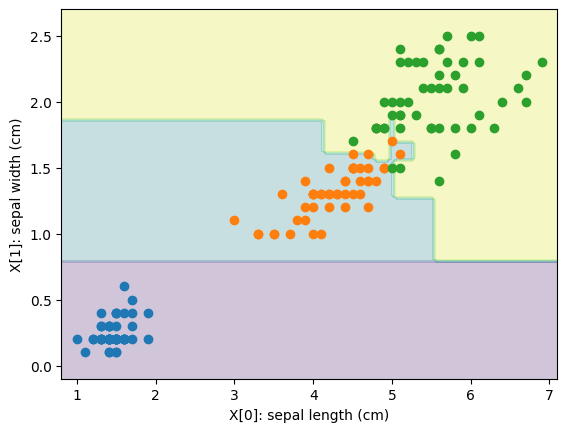

In [9]:
my_tree = MyTree()
plot_2d_decision_regions(my_tree, iris_x, iris_y)

#### Implementação Scikit-Learn

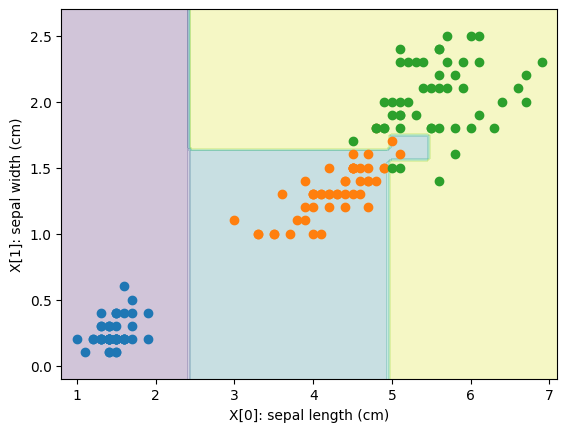

In [10]:
tree_sklearn = DecisionTreeClassifier(random_state=seed)
plot_2d_decision_regions(tree_sklearn, iris_x, iris_y)

### Comparação: Acurácia e validação cruzada

In [11]:
show_comparison(iris_x, iris_y)

,Zero R,Árvore (prof.),Árvore (scikit),Árvore (minha)
Acurácia,0.333333,0.993333,0.993333,0.980000
Validação cruzada (média),0.333333,0.953333,0.953333,0.966667


## Outros datasets

### Dataset 1: Electricity

[Dataset (OpenML)](https://www.openml.org/search?type=data&sort=runs&status=active&qualities.NumberOfClasses=%3D_2&id=151)


In [12]:
from sklearn.datasets import fetch_openml

dataset = fetch_openml(data_id=151)
ds1_df_x: DataFrame = dataset['data'].select_dtypes(include=['number'])
ds1_df_y: DataFrame = dataset['target'].map({'DOWN': 0, 'UP': 1})

In [13]:
dataset['DESCR']

'**Author**: M. Harries, J. Gama, A. Bifet  \n**Source**: [Joao Gama](http://www.inescporto.pt/~jgama/ales/ales_5.html) - 2009  \n**Please cite**: None  \n\n**Electricity** is a widely used dataset described by M. Harries and analyzed by J. Gama (see papers below). This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations.\n\nThe dataset (originally named ELEC2) contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states a

In [14]:
ds1_x, ds1_y = numpy.array(ds1_df_x.drop('date', axis=1)), numpy.array(ds1_df_y)
show_comparison(ds1_x, ds1_y)

,Zero R,Árvore (prof.),Árvore (scikit),Árvore (minha)
Acurácia,0.575455,0.999890,0.999978,0.879039
Validação cruzada (média),0.575455,0.650819,0.666951,0.690784


### Dataset 2: Arrhythmia

[Dataset (OpenML)](https://www.openml.org/search?type=data&id=1017&sort=runs&status=active)


In [15]:
from sklearn.datasets import fetch_openml
from pandas import DataFrame

dataset = fetch_openml(data_id=1017)
ds2_df_x: DataFrame = dataset['data'].select_dtypes(include=['number'])
ds2_df_y: DataFrame = dataset['target'].map({'N': 0, 'P': 1})

In [16]:
dataset['DESCR']

"**Author**:   \n**Source**: Unknown - Date unknown  \n**Please cite**:   \n\nBinarized version of the original data set (see version 1). The multi-class target feature is converted to a two-class nominal target feature by re-labeling the majority class as positive ('P') and all others as negative ('N'). Originally converted by Quan Sun.\n\nDownloaded from openml.org."

In [17]:
ds2_x, ds2_y = numpy.array(ds2_df_x.dropna(axis='columns')), numpy.array(ds2_df_y)
show_comparison(ds2_x, ds2_y)

,Zero R,Árvore (prof.),Árvore (scikit),Árvore (minha)
Acurácia,0.542035,1.000000,1.000000,0.542035
Validação cruzada (média),0.542051,0.661661,0.690183,0.593162


### Dataset 3: Communities and crime binary

[Dataset (OpenML)](https://www.openml.org/search?type=data&id=43891&sort=runs&status=active)


In [18]:
from sklearn.datasets import fetch_openml
from pandas import DataFrame

dataset = fetch_openml(data_id=43891)
ds3_df_x: DataFrame = dataset['data'].select_dtypes(include=['number'])
ds3_df_y: DataFrame = dataset['target'].map({'1': 1, '0': 0})

In [19]:
dataset['DESCR']

"Communities and Crime (Binarized) \n The following changes were introduced to OpenML Dataset 315.\n * binarized 'racepctblack' at 0.06 \n binarized 'ViolentCrimesPerPop' at 0.2\n\nDownloaded from openml.org."

In [20]:
ds3_x, ds3_y = numpy.array(ds3_df_x.dropna(axis='columns')), numpy.array(ds3_df_y)
show_comparison(ds3_x, ds3_y)

,Zero R,Árvore (prof.),Árvore (scikit),Árvore (minha)
Acurácia,0.576229,1.000000,1.000000,0.972417
Validação cruzada (média),0.576228,0.752775,0.731728,0.709128


## Análise

Os resultados de cada implementação (minha, scikit e a do professor) variaram bastante por dataset, ou seja, não teve uma implementação que obteve os melhores resultados em todos os conjuntos de dados. Todas implementações apresentaram seus melhores resultados no Iris dataset, acredito que o fato de todas features serem numéricas tenha colaborado para isso, diferente dos outros três datasets, que ignorei todas as características não numéricas.